<a href="https://colab.research.google.com/github/paulandrea0/TEMP_Clasificando-con-AutoEncoders/blob/main/Notebook_MiguelSotaquira01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df_test = pd.read_csv('/gdrive/MyDrive/Codificando Bits/consultorías/2022-07-PaulaAndreaMontenegro/VT_Z_teste.csv')
df_train = pd.read_csv('/gdrive/MyDrive/Codificando Bits/consultorías/2022-07-PaulaAndreaMontenegro/VT_Z_train.csv') 

Mounted at /gdrive


In [ ]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,10983,10984,10985,10986,10987,10988,10989,10990,10991,10992
0,109.0,96.0,138.0,137.0,120.0,84.0,68.0,69.0,110.0,114.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59.0,77.0,127.0,203.0,200.0,159.0,140.0,243.0,265.0,250.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-81.0,-65.0,-47.0,-39.0,-67.0,-57.0,17.0,138.0,200.0,197.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,143.0,127.0,146.0,188.0,152.0,112.0,122.0,96.0,130.0,222.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26.0,12.0,8.0,3.0,18.0,22.0,49.0,39.0,32.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Cada fila es una señal.

- Train: 1480 datos, tamaño máximo 13348
- Test: 256 datos, tamaño máximo 10993

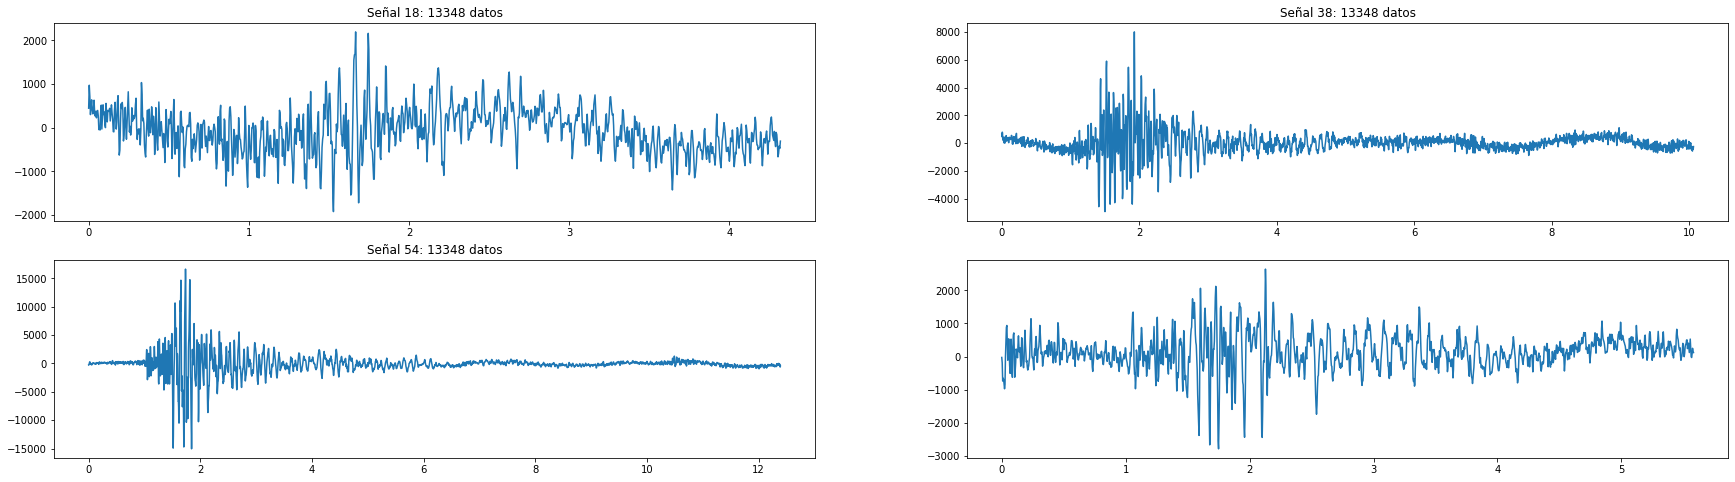

In [ ]:
# Algunas señales
idx = [60, 18, 38, 54]
fs = 50
plt.figure(1, figsize=(30, 8))

for i, index in enumerate(idx):
    signal = df_train.values[index,:]
    N = len(signal)
    t = np.linspace(0,fs,N)
    plt.title(f'Señal {index}: {N} datos')
    plt.subplot(2,2,i+1)
    plt.plot(t,signal)



In [ ]:
# Calcular cantidad de bloques con NaNs (https://stackoverflow.com/questions/15062205/finding-start-and-stops-of-consecutive-values-block-in-python-numpy-pandas)

def get_nans_blocks_length(a):
    """
    Returns 1D length of np.nan s block in sequence depth wise (last axis).
    """
    nan_mask = np.isnan(a)
    start_nans_mask = np.concatenate((np.resize(nan_mask[...,0],a.shape[:-1]+(1,)),
                                 np.logical_and(np.logical_not(nan_mask[...,:-1]), nan_mask[...,1:])
                                 ), axis=a.ndim-1)
    stop_nans_mask = np.concatenate((np.logical_and(nan_mask[...,:-1], np.logical_not(nan_mask[...,1:])),
                                np.resize(nan_mask[...,-1], a.shape[:-1]+(1,))
                                ), axis=a.ndim-1)

    start_idxs = np.where(start_nans_mask)
    stop_idxs = np.where(stop_nans_mask)

    counts = stop_idxs[-1] - start_idxs[-1] + 1
    return len(counts)

In [ ]:
# Calcular el porcentaje de NaNs en cada señal y la
# cantidad correspondiente de bloques NaNs
df = df_train.copy()
pctg_list = [0]*df.shape[0]
nblocks = [0]*df.shape[0]
for index, row in df.iterrows():
    signal = df.values[index,:]
    N = len(signal)
    pctg_list[index] = 100*np.argwhere(np.isnan(signal)).shape[0]/N
    nblocks[index] = get_nans_blocks_length(signal)

d = {'% NaNs': pctg_list, 'Nro. bloques NaNs': nblocks}
df_stats = pd.DataFrame(data=d)


In [ ]:
df_stats['Nro. bloques NaNs'].min()

0

Resumen:

- **Entrenamiento**: en promedio cada serie tiene un 83% de datos faltantes, con rangos que van del 0% hasta el 98%.
- **Prueba**: en promedio cada serie tiene un 78% de datos faltantes, con rangos que van desde el 0% hasta el 93%

Algunas series no contienen ningún dato faltante, mientras que otras contienen sólo un bloque consecutivo de datos faltantes (posiblemente al final de la misma)

## Pre-procesamiento

1. Eliminar NaNs en cada señal (reemplazar por ceros)
2. Crear máscaras para cada señal
3. Crear x_train y x_test, de Nfilas x timesteps, siendo timesteps el mismo en ambos casos

In [ ]:
mask = np.isnan(signal) 
idx = np.where(~mask)[0] # Índices
l_signal = idx.shape[0]
print(idx.shape)
print(mask.shape)

idx = np.where(~mask,np.arange(mask.shape[1]),0)
print(idx.shape)

(1449,)
(13348,)


IndexError: ignored

In [ ]:
# 1. Reemplazar NaNs con ceros

def preprocess_df(df):
    N = df.shape[0]
    data = [None]*N
    start_end_idx = [None]*N
    l_signals = [None]*N
    for index, row in df.iterrows():
        signal = row.values
        mask = np.isnan(signal)
        idx = np.where(~mask)[0] # Índices que contienen la señal
        l_signal = idx.shape[0] # Tamaño de la señal

        # Almacenar
        data[index] = signal[idx[0]:idx[-1]]
        start_end_idx[index] = (idx[0], idx[-1])
        l_signals[index] = l_signal
    
    return data, start_end_idx, l_signals

In [ ]:
data_train, s_e_idx_train, l_signals_train = preprocess_df(df_train)
data_test, s_e_idx_test, l_signals_test = preprocess_df(df_test)

In [ ]:
# Longitud máxima total
LMAX = max(max(l_signals_train),max(l_signals_test))

In [ ]:
# Crear arrays de entrenamiento y prueba usando rellenado con ceros
def create_datasets_masks(data, length=LMAX):
    datasets = [None]*len(data)
    masks = [None]*len(data)
    for idx, signal in enumerate(data):
        array = np.zeros((length))
        mask = np.zeros((length))
        if len(signal) < length:
            array[0:len(signal)] = signal
            mask[0:len(signal)] = 1
        else:
            array = signal
        
        datasets[idx] = array
        masks[idx] = mask
    
    datasets_array = np.asarray(datasets)
    masks_array = np.asarray(masks)
    
    return datasets_array, masks_array

x_train_data, x_train_masks = create_datasets_masks(data_train)
x_test_data, x_test_masks = create_datasets_masks(data_test)

In [ ]:
print(x_train_data.shape)
print(x_train_masks.shape)
print(x_test_data.shape)
print(x_test_masks.shape)

(1480, 13348)
(1480, 13348)
(256, 13348)
(256, 13348)


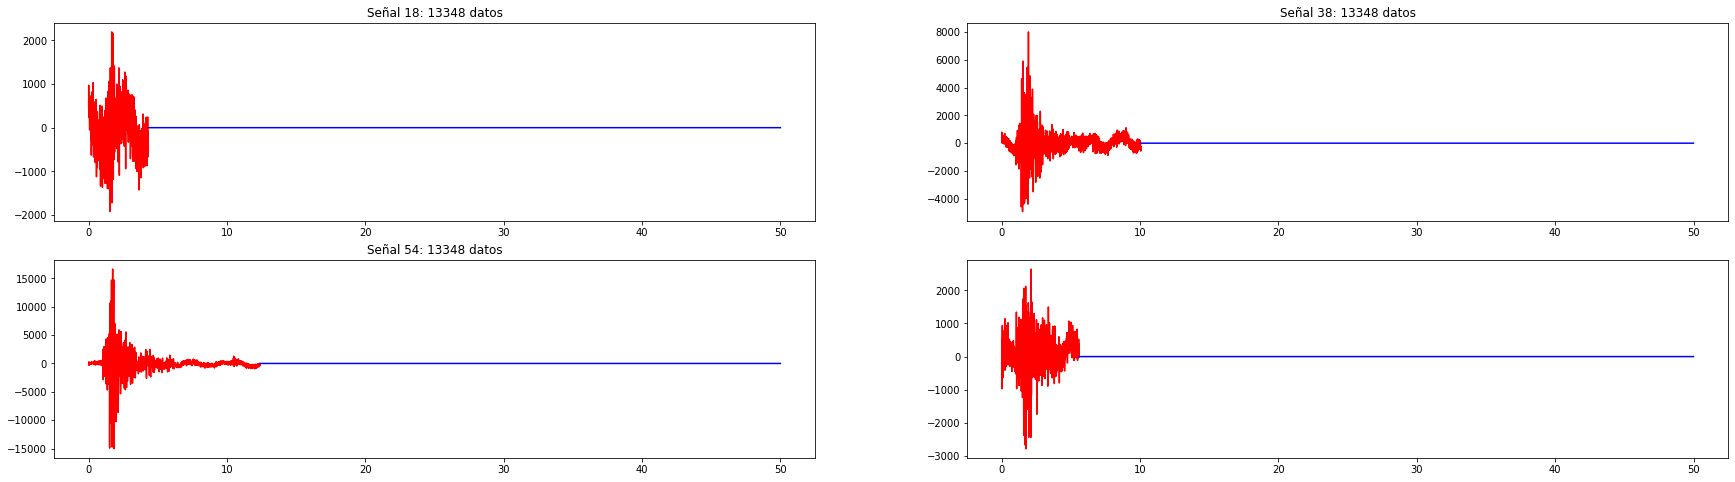

In [ ]:
# Mostrar algunas señales

idx = [60, 18, 38, 54]
fs = 50
plt.figure(1, figsize=(30, 8))

for i, index in enumerate(idx):
    signal = x_train_data[index,:]
    mask = x_train_masks[index,:]
    mask_ids = np.where(mask==1)[0]
    N = len(signal)
    t = np.linspace(0,fs,N)
    plt.title(f'Señal {index}: {N} datos')
    plt.subplot(2,2,i+1)
    plt.plot(t[mask_ids[0]:mask_ids[-1]],signal[mask_ids[0]:mask_ids[-1]],'r')
    plt.plot(t[mask_ids[-1]+1:-1],signal[mask_ids[-1]+1:-1],'b')

**Escalamiento**:

Se hará escalamiento min/max en el rango de -1 a 1

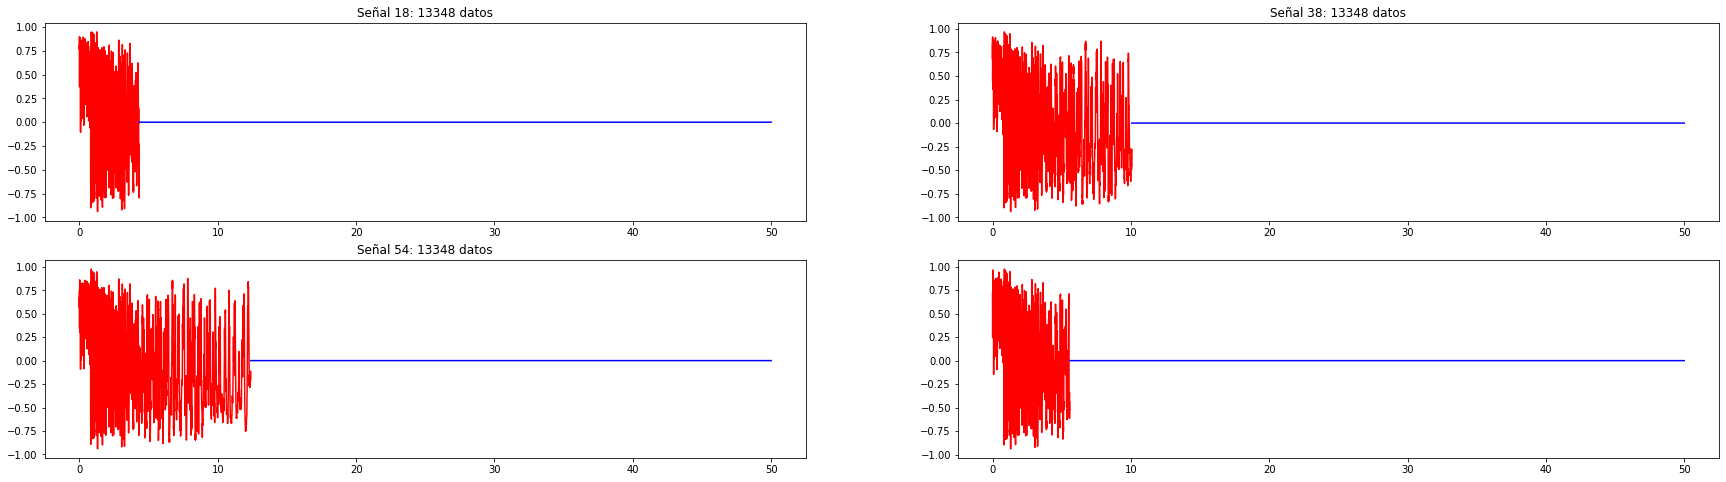

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(x_train_data)
X_train = np.multiply(scaler.transform(x_train_data), x_train_masks)
X_test = np.multiply(scaler.transform(x_test_data), x_test_masks)

idx = [60, 18, 38, 54]
fs = 50
plt.figure(1, figsize=(30, 8))

for i, index in enumerate(idx):
    signal = X_train[index,:]
    mask = x_train_masks[index,:]
    mask_ids = np.where(mask==1)[0]
    N = len(signal)
    t = np.linspace(0,fs,N)
    plt.title(f'Señal {index}: {N} datos')
    plt.subplot(2,2,i+1)
    plt.plot(t[mask_ids[0]:mask_ids[-1]],signal[mask_ids[0]:mask_ids[-1]],'r')
    plt.plot(t[mask_ids[-1]+1:-1],signal[mask_ids[-1]+1:-1],'b')

Creo que el minmaxscaler no funcionará: me distorsiona las señales.

Probaremos con standard scaler pero aplicado sólo a la porción que contiene la señal

In [ ]:
# Standard scaling aplicado sólo a non-zero values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train_data[np.any(x_train_data,-1)])

X_train = np.zeros(x_train_data.shape)
X_test = np.zeros(x_test_data.shape)

X_train[np.any(x_train_data,-1)] = scaler.transform(x_train_data[np.any(x_train_data,-1)])
X_test[np.any(x_test_data,-1)] = scaler.transform(x_test_data[np.any(x_test_data,-1)])

# Asegurar enmascaramiento
X_train = np.multiply(X_train, x_train_masks)
X_test = np.multiply(X_test, x_test_masks)

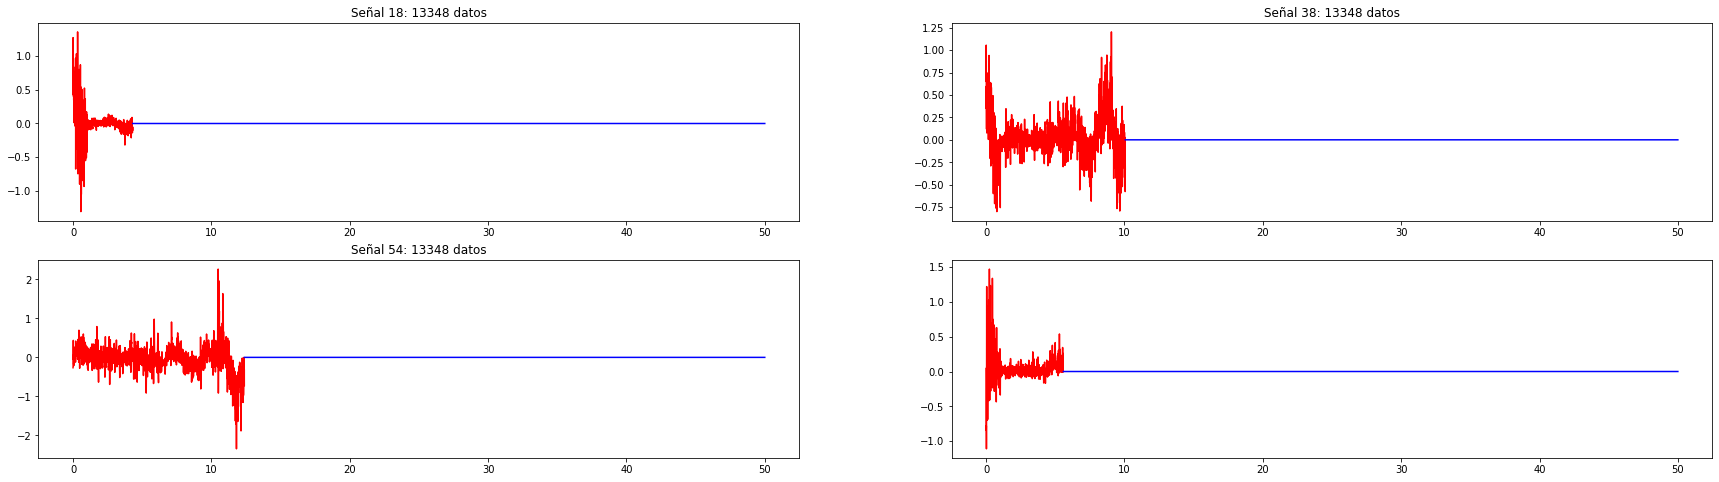

In [ ]:
idx = [60, 18, 38, 54]
fs = 50
plt.figure(1, figsize=(30, 8))

for i, index in enumerate(idx):
    signal = X_train[index,:]
    mask = x_train_masks[index,:]
    mask_ids = np.where(mask==1)[0]
    N = len(signal)
    t = np.linspace(0,fs,N)
    plt.title(f'Señal {index}: {N} datos')
    plt.subplot(2,2,i+1)
    plt.plot(t[mask_ids[0]:mask_ids[-1]],signal[mask_ids[0]:mask_ids[-1]],'r')
    plt.plot(t[mask_ids[-1]+1:-1],signal[mask_ids[-1]+1:-1],'b')

No me convence aún. Las señales tienen mejores rangos de variación en amplitud pero en todo caso no se parecen a las señales originales.

Creo que lo más conveniente es escalar cada serie de tiempo de manera individual, pues cada una tiene un rango diferente:

In [ ]:
def create_datasets_masks(data, length=LMAX):
    datasets = [None]*len(data)
    masks = [None]*len(data)
    for idx, signal in enumerate(data):
        array = np.zeros((length))
        mask = np.zeros((length))
        smin = min(signal)
        smax = max(signal)
        smean = np.mean(signal)
        signal = signal - smean
        if len(signal) < length:
            array[0:len(signal)] = (signal-smin)/(smax-smin)*(2) - 1
        else:
            array = (signal-smin)/(smax-smin)*(2) - 1
        mask[0:len(signal)] = 1
        
        datasets[idx] = array
        masks[idx] = mask
    
    datasets_array = np.asarray(datasets)
    masks_array = np.asarray(masks)
    
    return datasets_array, masks_array

x_train_data, x_train_masks = create_datasets_masks(data_train)
x_test_data, x_test_masks = create_datasets_masks(data_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


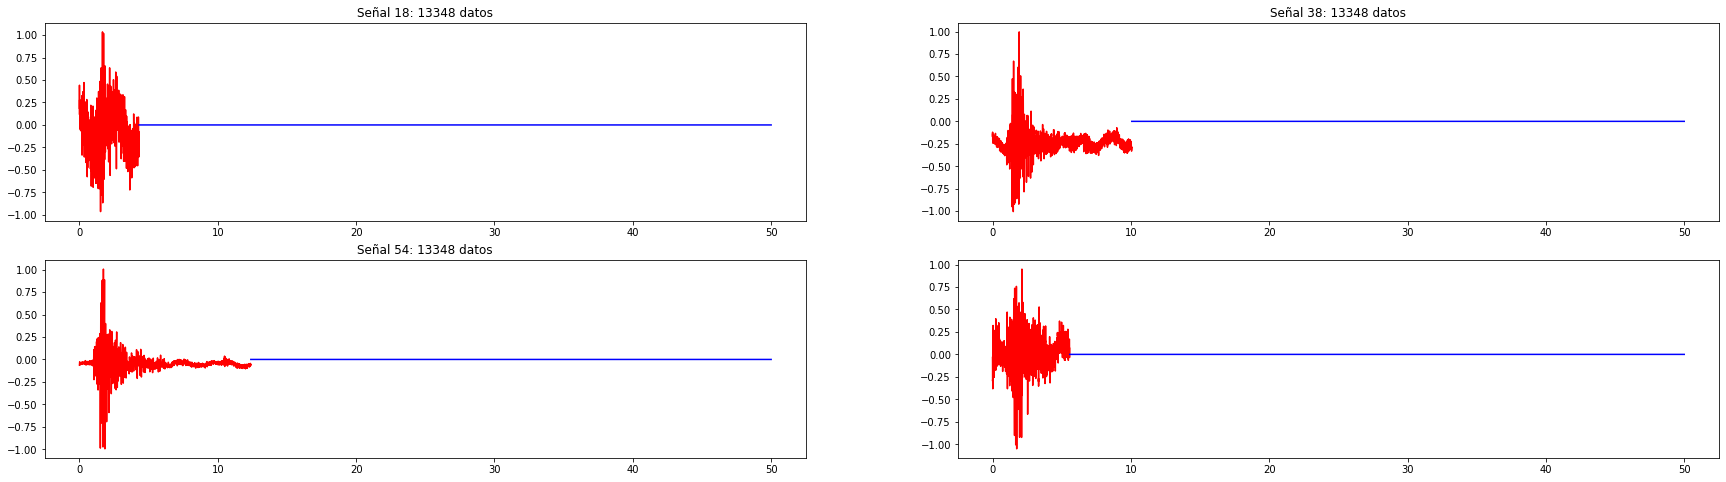

In [ ]:
idx = [60, 18, 38, 54]
fs = 50
plt.figure(1, figsize=(30, 8))

for i, index in enumerate(idx):
    signal = x_train_data[index,:]
    mask = x_train_masks[index,:]
    mask_ids = np.where(mask==1)[0]
    N = len(signal)
    t = np.linspace(0,fs,N)
    plt.title(f'Señal {index}: {N} datos')
    plt.subplot(2,2,i+1)
    plt.plot(t[mask_ids[0]:mask_ids[-1]],signal[mask_ids[0]:mask_ids[-1]],'r')
    plt.plot(t[mask_ids[-1]+1:-1],signal[mask_ids[-1]+1:-1],'b')

Referencias sugeridas:

- Autoencoders LSTM: https://machinelearningmastery.com/lstm-autoencoders/
- Usar masking en Keras: https://stackoverflow.com/questions/58025115/variable-length-input-for-lstm-autoencoder-keras